# Trabajo práctico 5

Implementación de un sistema de comunicaciones básico 

## Ejercicio 1 

Diseño de sistemas de comunicaciones básico que contenga los bloques de la figura 

![Bloques del sistema de comunicaciones](./imgs/diagrama_bloques_sistema.png)


La representación de la **PRBS9** es simulada mediante una función que crea una  **secuencia aleatoria** en este ejercicio. El sistema tendrá: 

* Generador de símbolos aleatorios 
* Sobremuestreo 
* Filtro RC 
* Downsampler 
* Slicer
* BER checker 


La resolución de los coeficientes y en todos los restantes bloques de **punto flotante**

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tool.DSPtools import *

Definimos los parámetros del sistema, teniendo en cuenta:  

**Frecuencia de clock** : 100MHz. Este es el clock más rápido que se tiene, por lo que se usa para realizar el **sobremuestreo** y se utiliza uno N veces menor para el resto 


In [2]:
clk = 100e6                 #Clock Freq.  
N = 4                      #Oversampling 
BR = clk / N                #Baud Rate 
rolloff = 0.5               
fs = N*BR                   #Sample Freq. 
Ts = 1/fs                   #Sample T. 
T = 1/BR                    #Symbol sep 
M = 2                       #Symbols (levels) 
Nsymb = 1e3                 #Simulation Length 
NB = 6                      #RC taps 

### 1) Generamos los símbos aleatorios (Modulación PAM 2 ) 

In [3]:
def RandBinarySeq(M,Nsymb):
    return 2 * np.random.randint(M, size = int(Nsymb)) - (M-1) 

In [4]:
akI = RandBinarySeq(M,Nsymb)
akQ = RandBinarySeq(M,Nsymb)

### 2) Sobremuestreamos los símbolos generados agregando ceros cada N muestras 

In [5]:
def upsampler(symb,N): 
    symb_up = np.zeros(N*len(symb),dtype=int)
    symb_up[: :N] = symb                     #Cada N igualo a symb
    return  symb_up

In [6]:
akIup = upsampler(akI,N)
akQup = upsampler(akQ,N)

 * Comprobamos que los símbolos se hayan creado y sobremuestreado correctamente 

In [7]:
print(akI[:4])
print(akQ[:4])
print(akIup[:4*N])
print(akQup[:4*N])

[-1 -1 -1 -1]
[1 1 1 1]
[ 0 -1  0  0  0 -1  0  0  0 -1  0  0  0 -1  0  0]
[0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0]


 * Graficamos histogramas para lo símbolos aleatorios

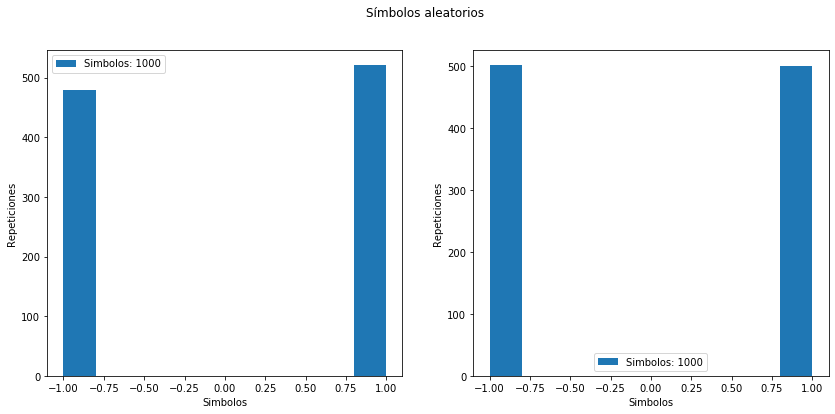

In [8]:
plt.figure(figsize=[14,6])
plt.suptitle("Símbolos aleatorios")
plt.subplot(1,2,1)
plt.hist(akI,label='Simbolos: %d' % Nsymb)
plt.legend()
plt.xlabel('Simbolos')
plt.ylabel('Repeticiones')
plt.subplot(1,2,2)
plt.hist(akQ,label='Simbolos: %d' % Nsymb)
plt.legend()
plt.xlabel('Simbolos')
plt.ylabel('Repeticiones')
plt.show()

* Graficamos los símbolos sobremuestreados

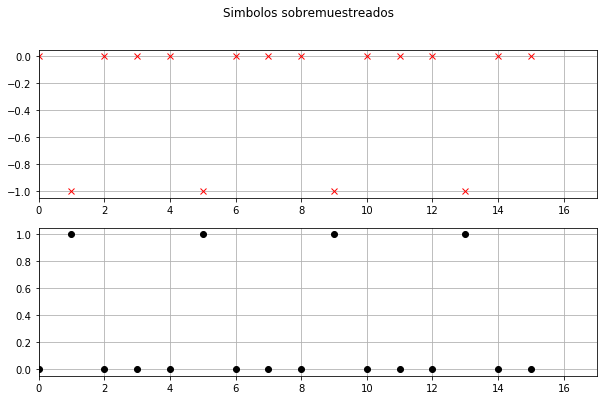

In [9]:
plt.figure(figsize=[10,6])
plt.suptitle("Simbolos sobremuestreados")
plt.subplot(2,1,1)
plt.plot(akIup[:4*N],'rx')
plt.xlim(0,4*N+1)
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(akQup[:4*N],'ko')
plt.xlim(0,4*N+1)
plt.grid(True)
plt.show()

### 3) Filtro conformador de pulsos *pulse shaping* 

Convolucionamos los pulsos sobremuestreados con un coseno realzado 

In [10]:
(t,h) = rcosine(rolloff,T,N,NB,Norm=False)

In [11]:
txSymbI = np.convolve(h,akIup,'same')       #'same'para alinear con akIup
txSymbQ = np.convolve(h,akQup,'same')       #Para el ej2 Tiene que ser con full
                                            #para emular el retardo en el hard

* Respuesta en frecuencia 

Text(0, 0.5, 'Amplitud')

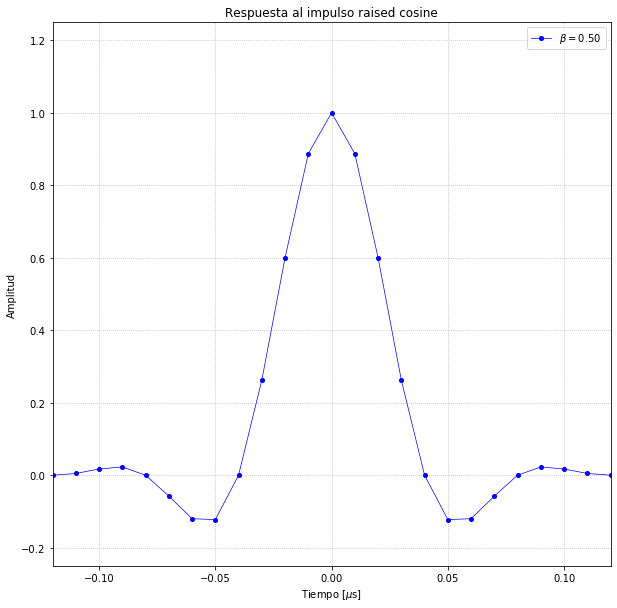

In [12]:
us = 1e6
plt.figure(figsize = [10,10])
plt.grid(linestyle=':', linewidth=0.75)
plt.plot(t*us,h,'b-o',linewidth = 0.7,
         markersize=4,label=r'$\beta=%2.2f$'%rolloff)

plt.title ('Respuesta al impulso raised cosine')
plt.legend()
plt.xlim(t[0]*us,t[-1]*us)
plt.ylim(-0.25,1.25)
plt.xlabel('Tiempo [$\mu$s]')
plt.ylabel('Amplitud')

* Respuesta en frecuencia 

In [13]:
NFTT = 1024 
[H,A,F] = resp_freq(h, Ts, NFTT)
H_dB = 20*np.log10(H)- 20*np.log10(H[0])

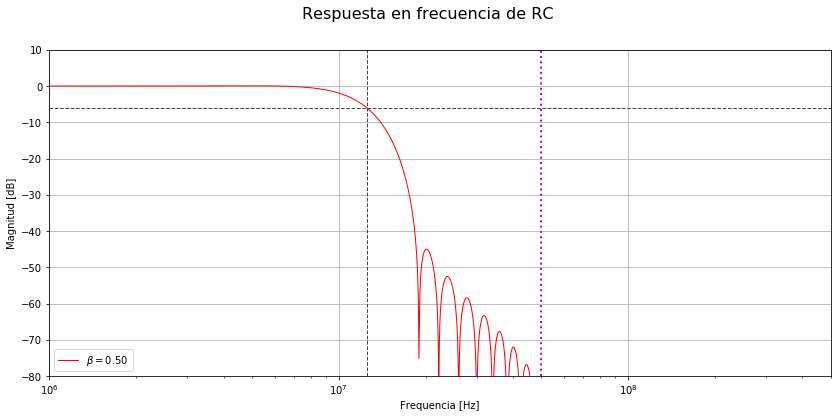

In [14]:
fig=plt.figure(figsize=[14,6])
fig.suptitle('Respuesta en frecuencia de RC', fontsize=16)

plt.semilogx(F,H_dB ,'r', lw=1.0, label=r'$\beta=%2.2f$'%rolloff)

plt.axvline(x=(1./Ts)/2.,color='m',linewidth=2.0,
           linestyle=":")
plt.axvline(x=(1./T)/2.,color='#454444',
            linewidth=1,linestyle="--") 
plt.axhline(y=20*np.log10(0.5),color='#454444',
            linewidth=1,linestyle="--")

plt.legend(loc=3)
plt.grid(True)
plt.xlim(10e5,F[-1]*10)
plt.ylim(-80,10)
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.show()

* Graficamos la señal transmitida S(t) 

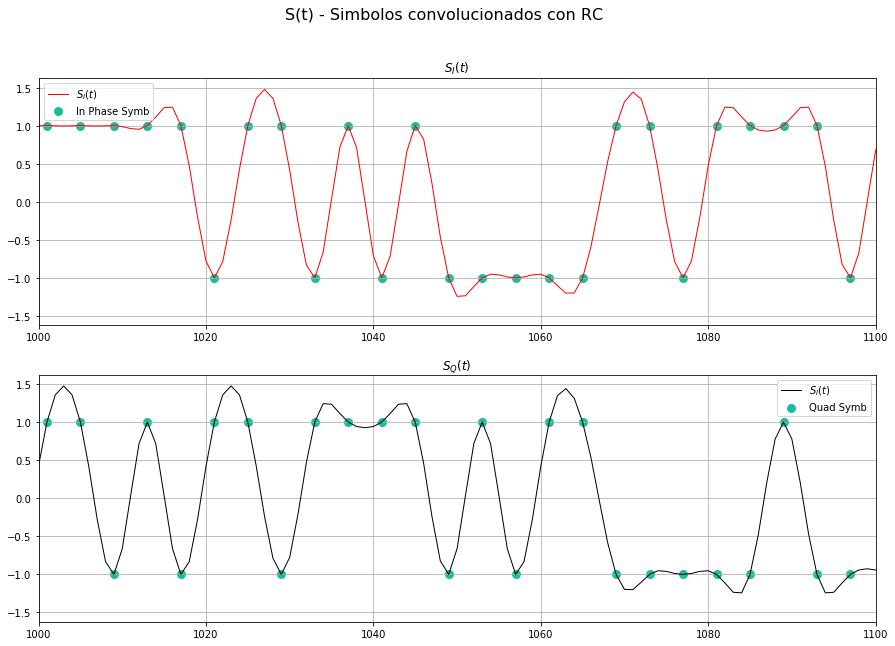

In [15]:
fig=plt.figure(figsize=[15,10])
fig.suptitle('S(t) - Simbolos convolucionados con RC', fontsize=16)

sp1= plt.subplot(2,1,1)
sp1.set_title("$S_I(t)$")
plt.plot(txSymbI,'r-',linewidth=1.0,label="$S_I(t)$")
plt.scatter(np.where(akIup!=0),akIup[akIup!=0],lw=3,
            label="In Phase Symb",color="#1abc9c")
plt.legend()
plt.xlim(1000,1100)
plt.grid(True)


sp2 = plt.subplot(2,1,2)
sp2.set_title("$S_Q(t)$")
plt.plot(txSymbQ,'k-',linewidth=1.0,label="$S_I(t)$")
plt.scatter(np.where(akQup!=0),akQup[akQup!=0],lw=3,
            label="Quad Symb",color="#1abc9c")
plt.legend()
plt.xlim(1000,1100)
plt.grid(True)


plt.show()

* Diagrama de ojo de lo símbolos transmitidos 

Text(0.5, 1.0, 'Quadrature')

<Figure size 1152x1152 with 0 Axes>

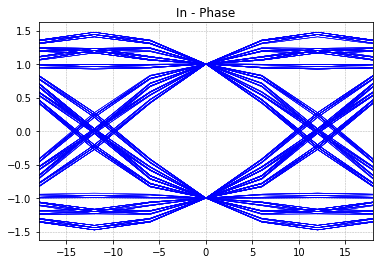

<Figure size 1152x1152 with 0 Axes>

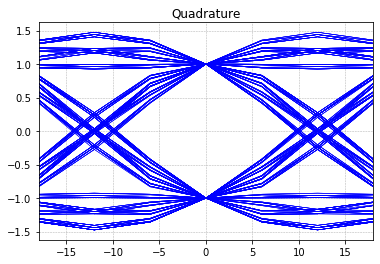

In [39]:
fig=plt.figure(figsize=[16,16])
guard=200
P=1
eyediagram(txSymbI[guard:-guard],N,P,NB)
plt.grid(linestyle='--', linewidth=0.5)
plt.title ('In - Phase')

fig=plt.figure(figsize=[16,16])
guard=200
P=1
eyediagram(txSymbQ[guard:-guard],N,P,NB)
plt.grid(linestyle='--', linewidth=0.5)
plt.title ('Quadrature')

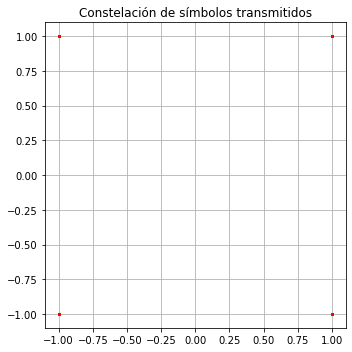

In [49]:
To=1
fig = plt.figure(figsize=[5,5])
                               
plt.plot(txSymbI[100+To:len(txSymbI)-(100-To):int(N)],                
        txSymbQ[100+To:len(txSymbQ)-(100-To):int(N)],                     
        '.r',lw=2.0,markersize=3)
plt.grid()
plt.title("Constelación de símbolos transmitidos")
plt.tight_layout()

### 4)  Downsampler 

Submuestreo la señal del transmisor (muestreo a t = KT) 

In [17]:
def DownSampler(symbUp,N,To): 
    symb = np.zeros(len(symbUp), dtype = int)
    symb = symbUp[To: :int(N)] 
    return symb 

In [55]:
To=1
rkI = DownSampler(txSymbI,N,To)
rkQ = DownSampler(txSymbQ,N,To)

### 5) Slicer

Implementamos una forma básica y simple de un slicer para PAM2 para completar el sistema de comunicación.

In [61]:
akIhat = [(1 if value >=0 else -1) for value in rkI]
akQhat = [(1 if value >=0 else -1) for value in rkQ]

* Volvemos a graficar la constelación para comprobar 

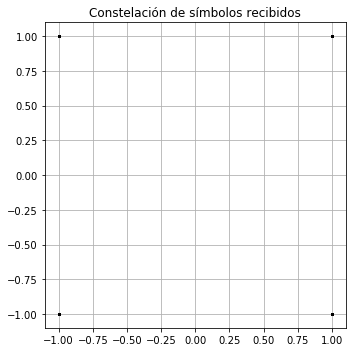

In [67]:
To=1
fig = plt.figure(figsize=[5,5])
                               
plt.plot(akIhat[100+To:len(akIhat)-(100-To):int(N)],                
        akQhat[100+To:len(akQhat)-(100-To):int(N)],                     
        '.k',lw=2.0,markersize=4)
plt.grid()
plt.title("Constelación de símbolos recibidos")
plt.tight_layout()

### 6) BER checker 

In [72]:
ErrorI=0
ErrorQ=0

for i in range(int(Nsymb)):
    if akI[i]!=akIhat[i]:
        ErrorI=0
    if akQ[i]!=akQhat[i]:
        ErrorQ=0

        
SERI = ErrorI/Nsymb
SERQ = ErrorQ/Nsymb

#Calculo de BER de forma simple, aproximada
BERI = SERI * (1/np.log2(M))
BERQ = SERQ * (1/np.log2(M))


print("Bit Error Rate In Phase = ",BERI )
print("Bit Error Rate Quadrature = ",BERQ )

Bit Error Rate In Phase =  0.0
Bit Error Rate Quadrature =  0.0


Comprobamos que no hay error en el sistema de comunicación básico implementado, ya que no hay diferencia entre los bits transmitidos y recibidos, lo cual corresponde con que no se simule un canal que adicione ruido o cualquier otra fuente de ruido que afecte al a información